In [12]:
%matplotlib inline
%run -i Device.ipynb

In [13]:
from matplotlib import pyplot,cm
from wernher import Controller

In [17]:
def simulate(xset,
             kp,ki,kd,
             m,b,k,x0,
             g=1,s=0,
             total_time=10,freq=10):
    npoints = (3*total_time + 1) * freq

    dev = Device()
    dev.m = m
    dev.b = b
    dev.k = k
    dev.x0 = x0
    dev.g = g
    dev.s = s
    
    cont = Controller()
    cont.kp = kp
    cont.ki = ki
    cont.kd = kd
    cont.cmin = -1
    cont.cmax = 1
    
    tt = np.linspace(-1,3*total_time, npoints)
    
    xx0 = np.zeros(tt.shape)
    xx0[tt>0] = xset
    xx0[tt>total_time] = 0
    xx0[tt>2*total_time] = 0.5
    
    xx = [0]
    vv = [0]
    aa = [0]
    
    t0 = tt[0]
    flip = False
    for t,x0 in zip(tt[1:],xx0[1:]):
        cont.set_point = x0
        a = cont(dev.x,t)
        x,v = dev(a,t-t0)
        aa.append(a)
        xx.append(x)
        vv.append(v)
        t0 = t
        
    return tt, xx0, aa, xx, vv, freq

def plot_simulation(tt,xx0,aa,xx,vv,freq):
    fig,ax = pyplot.subplots(1,1,figsize=(14,3))
    axr = ax.twinx()
    
    for a,s,c in ([ax,'left','blue'],[axr,'right','red']):
        a.spines[s].set_color(c)
        a.tick_params(axis='y', colors=c)
        a.title.set_color(c)
    axr.spines['left'].set_visible(False)
    
    opts = dict(alpha=0.4, lw=4)
    ptset, = ax.plot(tt, xx0, color='blue', **opts)
    ptval, = ax.plot(tt, xx, color='green', **opts)
    
    ptcont, = axr.plot(tt, aa, color='red', **opts)
    ptvel,  = axr.plot(tt, vv, color='magenta', **opts)
    
    ax.set_xlim(-1,None)
    ax.set_ylim(-0.5,1.5)
    axr.set_ylim(-1.05,1.05)
    
    ax.set_title('Control frequency: {} Hz'.format(freq))
    ax.set_xlabel(r'time (s)')
  
    l = ax.legend((ptset,ptcont,ptval,ptvel), ('set point','control','actual','velocity'),
              loc='best')
    l.set_zorder(1)
    

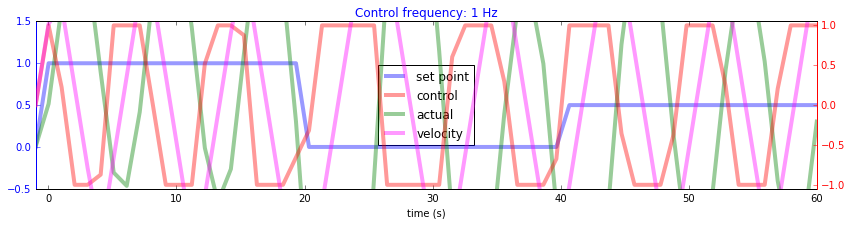

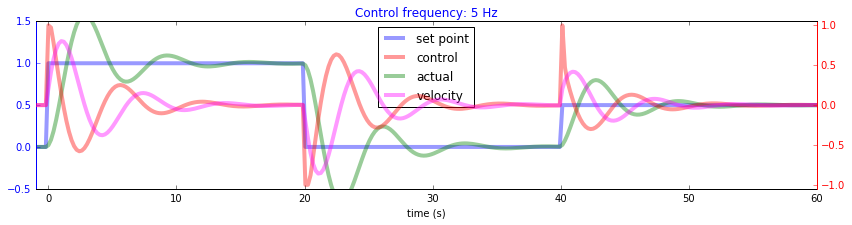

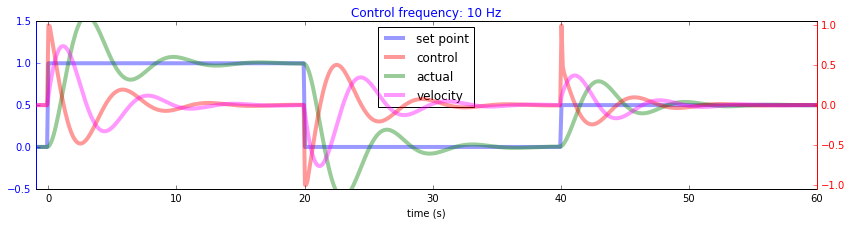

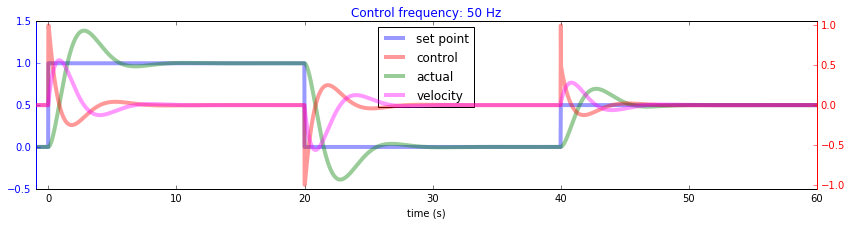

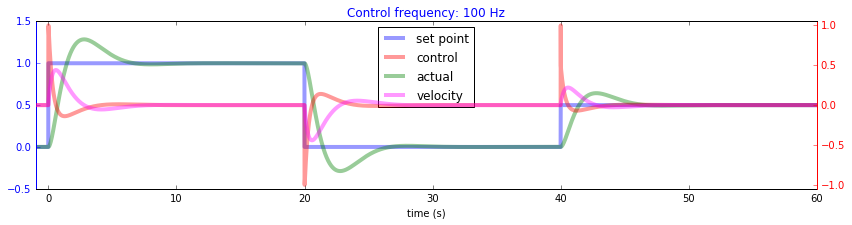

In [18]:
for freq in [1,5,10,50,100]: #,500,1000,5000]:
    _=plot_simulation(*simulate(xset=1,
                  kp=1, ki=0.5, kd=1,
                  m=1, b=0, k=0, x0=0,
                  g=1, s=0,
                  total_time=20, freq=freq))

NameError: name 'xset' is not defined

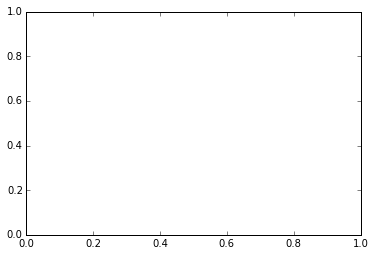

In [8]:
kk = np.linspace(0,3,20)
data = np.empty((20,100))
for i,k in enumerate(kk):
    data[i][:] = simulate(xset=10*π/180,
                kp=1.3, ki=0.5, kd=k,
                m=1733, b=0, k=1000, x0=0,
                g=5000, s=0,
                total_time=10, npoints=100)[3]

fig,ax = pyplot.subplots()
im = ax.imshow(data,
          origin='lower', aspect='auto',
          vmin=xset-0.2*xset, vmax=xset+0.2*xset,
          extent=[-1,10,kk.min(),kk.max()],
          cmap=cm.seismic)
_=ax.set_xlabel('t')
_=ax.set_ylabel('K')
_=ax.grid(True)
cb=pyplot.colorbar(im)
print('xset:',xset)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in double_scalars


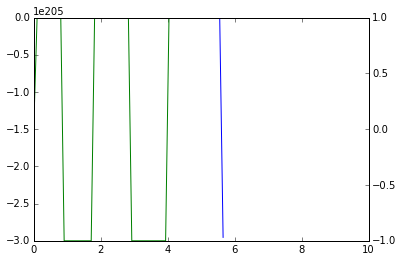

In [5]:
moi = 1733 # kg m^2
torque = 5000 # kg m^2 / s^2

# We want to be able to rotate at about 3 deg / s
# so 30 deg in 10 seconds
npoints = 100
tt = np.linspace(0,10,npoints)
xx = np.empty((npoints,))
vv = np.empty((npoints,))
cc = np.empty((npoints,))

dev = LinearDevice(t=0, x=-15, v=0, inertia=1733, drag=1, max_force=5000)
con = Controller(set_point=0, kp=1, ki=0.6, kd=1, t0=0)
con.min = -1
con.max = 1
for j,t in enumerate(tt):
    c = con(dev.x,t)
    x = dev(c,t)
    cc[j] = c
    xx[j] = x
    vv[j] = dev.v

fig,ax = pyplot.subplots()
_=ax.plot(tt,xx, color='blue')
axr = ax.twinx()
_=axr.plot(tt,cc, color='green')

In [184]:
print(xx[-22:-18])
print(cc[-22:-18])
print(vv[-22:-18])

[  3.25994504e+04   1.08330393e+07   1.36327712e+12   2.17164011e+22]
[-1. -1. -1. -1.]
[  1.35347284e+06   1.68704203e+11   2.65422680e+21   6.65207778e+41]


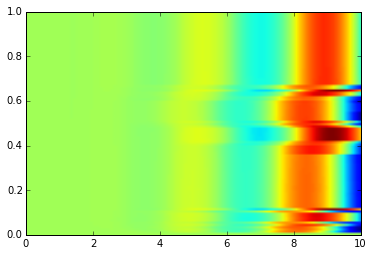

In [32]:
moi = 1733 # kg m^2
torque = 5000 # kg m^2 / s^2


kkp = np.linspace(0,1,100)
tt = np.linspace(0,10,100)
xx = np.empty((100,100))
cc = np.empty((100,100))

for i,kp in enumerate(kkp):
    dev = LinearDevice(t=0, x=10, v=0, inertia=1733, max_force=5000)
    con = Controller(set_point=0, kp=kp, kd=0, ki=0, t0=0)
    for j,t in enumerate(tt):
        c = con(dev.x,t)
        x = dev(c,t)
        cc[i,j] = c
        xx[i,j] = x

pyplot.imshow(xx, extent=[0,10,0,1],origin='lower',aspect='auto')

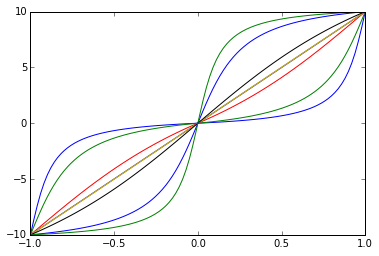

In [102]:
from numpy import tan, arctan, sign
from numpy import pi as π

def control_force(g,s):
    if s == 0:
        def _fn(c):
            return g * c
    elif s > 0:
        def _fn(c):
            return g * arctan(s*c) / arctan(s)
    else:
        def _fn(c):
            return sign(c) * g * (1 - arctan(s*(1-abs(c))) / arctan(s))
    return _fn

cc = np.linspace(-1,1,100)

fig,ax = pyplot.subplots()
for s in [-10,-5,-1,-0.1,0,.1,1,5,10]:
    ax.plot(cc, control_force(10,s)(cc))

In [31]:
arctan(1) == π/4

True

In [30]:
tan(2/π)

0.7393029504866041